# Introduction

Welcome to your assignment this week! 


To better understand fairness in AI, in this assignment, we will look at an **Income Classifier** use case.

<img src="images/intro.png" width="450"/> 

Ensuring fairness in a classifier that predicts income is of paramount importance due to the significant impact it can have on individuals and society as a whole. Inaccurate or biased predictions can perpetuate existing inequalities, reinforce discriminatory practices, and contribute to social and economic disparities.

By exploring fairness in income prediction classifiers, we aim to uncover and address potential biases that may arise in these systems. We seek to develop a deeper understanding of how AI algorithms can unintentionally perpetuate discrimination or unfairly disadvantage certain groups based on sensitive attributes such as gender, race, or ethnicity.

This assignment will delve into the complexities of fairness in income prediction and explore strategies to mitigate biases, promote equitable outcomes, and contribute to the development of AI systems that prioritize fairness and inclusivity.



# Objectives and Preliminaries


We consider fairness implications of training binary classifiers on a dataset where a binary sensitive attribute is observed. Let $\mathbf{y}^{(i)}$ be the class of the i$^{th}$ element on which we evaluate our classifier, let $\mathbf{a}$ be its sensitive attribute for which we are interested in ensuring fairness (female or male), and let $\mathbf{\hat{y}}^{(i)}$ be the classifier prediction. All of $\mathbf{y}^{(i)}$, $\mathbf{a}$, and $\mathbf{\hat{y}}^{(i)}$ are binary values (either 0 or 1). We will need the  three metrics defined below to analyze our classifier performance. 

Let $m$ be the number of examples we evaluate our classifier on, and $m_{\mathbf{a}=0}$, $m_{\mathbf{a}=1}$ are the number of examples with $\mathbf{a}^{(i)} = 0$ or $1$ respectively. First, we define the accuracy $\mathcal{Acc}$ as follows:

\begin{equation}
\mathcal{Acc} = \frac{1}{m} \sum_{i=1}^m \mathbb{1} \left[ \mathbf{\hat{y}}^{(i)} = \mathbf{y}^{(i)} \right] \tag{1} 
\end{equation}

where $\mathbb{1}$ is the indicator function (equal to 1 if the statement inside is true, 0 otherwise). 


Next, we define the *weighted accuracy* ($\mathcal{W\_Acc}$ ) of a classifier as the mean accuracy normalized by the size of the two groups:


\begin{equation}
\mathcal{W\_Acc} = \frac{1}{2} \left( \frac{1}{m_{\mathbf{a}=0}} \sum_{i=1}^m \mathbb{1} \left[ \mathbf{\hat{y}}^{(i)} = \mathbf{y}^{(i)}, \mathbf{a}^{(i)} = 0 \right] + \frac{1}{m_{\mathbf{a}=1}} \sum_{i=1}^m \mathbb{1} \left[ \mathbf{\hat{y}}^{(i)} = \mathbf{y}^{(i)}, \mathbf{a}^{(i)} = 1 \right]  \right) \tag{2}
\end{equation}

<!---
If we are interested in predicting $\mathbf{a}^{(i)}$ rather than $y^{(i)}$ , we can define this metric analogously as:

\begin{equation}
 = \frac{1}{2} \left( \frac{1}{m_{\mathbf{a}=0}} \sum_{i=1}^m \mathbb{1} \left[ \hat{\mathbf{a}}^{(i)} = \mathbf{a}^{(i)}, \mathbf{a}^{(i)} = 0 \right] + \frac{1}{m_{\mathbf{a}=1}} \sum_{i=1}^m \mathbb{1} \left[ \hat{\mathbf{a}}^{(i)} = \mathbf{a}^{(i)}, \mathbf{a}^{(i)} = 1 \right]  \right) \tag{3}
\end{equation}
-->

Finally, a fairness metric $\Delta_{DP}$ , which measures the (lack of) **Demographic Parity (DP)** of the classifier is defined as follows:


\begin{equation}
\Delta_{DP}= \left| \frac{1}{m_{\mathbf{a}=0}} \sum_{i=1}^m \mathbf{\hat{y}}^{(i)} \cdot (1-\mathbf{a}^{(i)}) - 
\frac{1}{m_{\mathbf{a}=1}} \sum_{i=1}^m  \mathbf{\hat{y}}^{(i)} \cdot \mathbf{a}^{(i)} \right| \tag{4}
\end{equation}



This is a lot of notation, but the concepts are fairly simple: (1) *accuracy measures* how often the classifier is correct; (2) *weighted accuracy* measures how often the classifier is correct if we weight each group equally, and (3) $\Delta_{DP}$ measures the absolute difference in predictions between the two groups .


In an ideal scenario, perfect fairness would mean that there is no disparity in predictions between the two groups female and male, resulting in $\Delta_{DP}$ equal to zero. However, achieving absolute fairness can be challenging or even impossible in practice, especially when considering the complexity of real-world data and the inherent trade-offs between accuracy and fairness.
Hence, a smaller value of $\Delta_{DP}$ indicates a smaller disparity in predictions between the groups and implies a fairer classifier.



# Fair Classification

Run the following cell to load the packages you will need for this assignment.

In [55]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# PLEASE DO NOT CHANGE THESE NUMBERS!
seed_value = 45


## Loading the data
Let’s start by looking at our data. In this assignment, we’ll use the  [Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult), which is a classic machine learning dataset, using data from a US census. The label $\mathbf{y}^{(i)}$ we are trying to predict is income, which is binarized to two categories (high income and low income). We are focused on evaluating fairness with regard to the sensitive attribute $\mathbf{a}$, which pertains to gender classification (0 for female and 1 for male). You can find more info about this data in the README file in the assignment folder. 


Let's first read our training and test datasets provided:



In [56]:
def load_data(remove_gender_feature=True):
    """    
        This function is used to load the training and test data from the Adult dataset. 
        It also loads the corresponding headers of the dataset. 
        The function allows for the option to remove the gender feature from the dataset if specified.

        Args:

            remove_gender_feature (bool): Optional parameter to remove the gender feature from the dataset. 
            Default is set to True.

        Returns:

            X_train (ndarray): Training data features.
            y_train (ndarray): Training data labels.
            a_train (ndarray): Training data sensitive attributes.
            X_test (ndarray): Test data features.
            y_test (ndarray): Test data labels.
            a_test (ndarray): Test data sensitive attributes.
            headers (list): List of headers corresponding to the dataset features.

    """
    # Load training data
    data = np.load('dataset/adult_train.npz')
    X_train = data['x']
    y_train = data['y']
    a_train = data['a']

    # Load test data
    data = np.load('dataset/adult_test.npz')
    X_test = data['x']
    y_test = data['y']
    a_test = data['a']

    # Load headers
    headers = []
    with open('dataset/adult_headers.txt', 'r') as file:
        for line in file:
            headers.append(line.strip())

    if remove_gender_feature:
        X_train = np.delete(X_train, [66, 67], axis=1)  # Delete features corresponding to gender
        X_test = np.delete(X_test, [66, 67], axis=1)  # Delete features corresponding to gender
        # Delete header corresponding to gender
        del headers[66]
        del headers[66]
    return X_train, y_train, a_train, X_test, y_test, a_test, headers


You've loaded:
- `X_train`: the trainig dataset.
- `y_train`: the trainig labels.
- `a_train`: the trainig sensitive attribute.

You have also loaded:
- `X_test`: the trainig dataset.
- `y_test`: the trainig labels.
- `a_test`: the trainig sensitive attribute.

Finally, you have loaded the headers in `headers`. 



## Features analysis

Let’s look just at the **training set** for now. 

Name the 10 features, which are most correlated with $\mathbf{y}$ , and the 10 which are most correlated with $\mathbf{a}$, as measured by (absolute) [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) (ignore any NaN correlations you see).

### <span style="color:red"><b>TASK 1</b></span>


Let's first implement a function that returns **top_correlated_features**:


In [57]:
def get_top_correlated_features(X, y, k=10):
    """
    Calculate Pearson correlation coefficients between features and target variable.
    Identify the top k features with the highest correlation coefficients.

    Args:
        X (ndarray): Input data matrix of shape (n_samples, n_features).
        y (ndarray): Target variable array of shape (n_samples,).
        k (int): Number of top correlated features to return (default: 10).

    Returns:
        top_indices (ndarray): Indices of the top k correlated features.
        correlations (ndarray): Corresponding correlation coefficients.

    """
    ## START YOU CODE HERE
    correlations = []
    for i in range(X.shape[1]):
        corr, _ = pearsonr(X[:, i], y.ravel())
        if np.isnan(corr):
            corr = 0.0  # treat NaN correlation as zero
        correlations.append(corr)
    
    correlations = np.array(correlations)
    abs_corr = np.abs(correlations)
    
    # Sort indices by absolute correlation, descending
    top_indices = np.argsort(abs_corr)[::-1][:k]
    ## END
    return top_indices, correlations
    

Print the 10 features, which are most correlated with $\mathbf{y}$:

In [58]:
X_train, y_train, a_train, X_test, y_test, a_test, headers = load_data(remove_gender_feature=False)

top_indices, correlations = get_top_correlated_features(X_train, y_train)
for i, idx in enumerate(top_indices):
    print(f'{i+1}- {headers[idx]}:  {correlations[idx]}')


1- marital-status_Married-civ-spouse:  0.44469615504632665
2- relationship_Husband:  0.4010352635774754
3- education_num:  0.3351539526909506
4- marital-status_Never-married:  -0.3184403250737911
5- age_u30:  -0.2381325319502168
6- hours-per-week:  0.22968906567081818
7- relationship_Own-child:  -0.22853196347383944
8- capital-gain:  0.22332881819540817
9- sex_Male:  0.21598015058403885
10- sex_Female:  -0.21598015058403885


Print the 10 features, which are most correlated with $\mathbf{a}$:

In [59]:
X_train, y_train, a_train, X_test, y_test, a_test, headers = load_data(remove_gender_feature=False)

top_indices, correlations = get_top_correlated_features(X_train, a_train)
for i, idx in enumerate(top_indices):
    print(f'{i+1}- {headers[idx]}:  {correlations[idx]}')
    

1- sex_Male:  0.9999999999999243
2- sex_Female:  -0.9999999999999243
3- relationship_Husband:  0.580135264800046
4- marital-status_Married-civ-spouse:  0.43180545811310456
5- relationship_Unmarried:  -0.3212732037336059
6- relationship_Wife:  -0.31931054800338166
7- occupation_Adm-clerical:  -0.2631477628435008
8- hours-per-week:  0.22930914902629881
9- marital-status_Divorced:  -0.2286211253030977
10- occupation_Craft-repair:  0.2231281775027463


### <span style="color:red"><b>TASK 2</b></span>

What do you observe from this feature analysis?

***

We can see from the feature analysis that several characteristics have a strong correlation with both the sensitive attribute (gender) and the target variable (income). The characteristics that have the most correlation with income are probably occupation, education, and weekly hours worked. Marital status, relationship, and occupation may be the factors most associated with gender, indicating that these variables reflect gender-related patterns in the data. This raises attention to the possibility that the classifier can unintentionally employ gender-related characteristics to generate predictions, which, if left unchecked, might provide unfair or biased results.


***

Let's explore the distribution of income by gender:

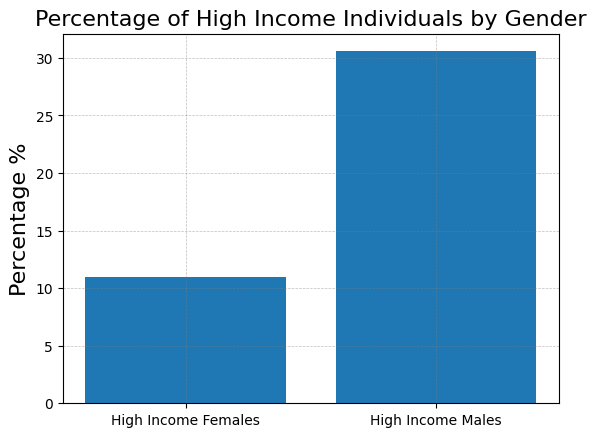

In [60]:
X_train, y_train, a_train, X_test, y_test, a_test, headers = load_data(remove_gender_feature=False)

# Sample binary arrays (replace these with your actual data)
gender = list(a_train.reshape(-1))
income = list(y_train.reshape(-1))


# Calculate the percentage of high-income individuals for each gender
total_females = gender.count(0)
total_males = gender.count(1)

high_income_females = sum(not g and i for g, i in zip(gender, income))
high_income_males = sum( g and i for g, i in zip(gender, income))

percentage_high_income_females = (high_income_females / total_females) * 100
percentage_high_income_males = (high_income_males / total_males) * 100

# Plot the histogram
categories = ['High Income Females', 'High Income Males']
percentages = [percentage_high_income_females, percentage_high_income_males]

plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.bar(categories, percentages)
plt.ylabel('Percentage %', fontsize=16)
plt.title('Percentage of High Income Individuals by Gender', fontsize=16)
plt.show()


From the graph displayed above, it is evident that **males generally exhibit higher income levels compared to females**. This observation highlights a potential bias in the data, which could result in the creation of an unfair classifier that relies on gender to predict whether an individual has a high or low income.

To delve deeper into this issue, we will explore it further in the subsequent part of this assignment.

## Evaluation Metrics

### <span style="color:red"><b>TASK 3</b></span>

Write the appropriate code to calculate the overall *accuracy* $\mathcal{Acc}$, *weighted accuracy* $\mathcal{W\_Acc}$, and $\Delta_{DP}$ on the test set. 

In [61]:
def compute_test_metrics(y_true, y_pred, a):
    """
    Compute test metrics to evaluate the performance and fairness of a binary classifier.

    This function takes in the ground truth labels, predicted labels, and the sensitive attribute
    and computes various metrics to assess the performance and fairness of the classifier.
    The function works with TensorFlow tensors and requires the input to be converted to
    TensorFlow tensors if needed.

    Args:
        y_true: Ground truth labels.
        y_pred: Predicted labels.
        a: Sensitive attribute.

    Returns:
        accuracy: Overall accuracy of the classifier.
        weighted_accuracy: Weighted accuracy considering the two sensitive groups.
        delta_dp: Difference in predictions between the two sensitive groups, measuring fairness.
        y_pred_labels_female_avg: Average predicted label for the female sensitive group.
        y_pred_labels_male_avg: Average predicted label for the male sensitive group.

    """
    # Convert inputs to TensorFlow tensors if needed.
    if not tf.is_tensor(y_true):
        y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    if not tf.is_tensor(y_pred):
        y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
    if not tf.is_tensor(a):
        a = tf.convert_to_tensor(a, dtype=tf.float32)

    ## START YOU CODE HERE
    # Flatten arrays
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    a = tf.reshape(a, [-1])

    # Convert predictions to binary (threshold 0.5) for accuracy metrics
    y_pred_binary = tf.cast(y_pred >= 0.5, tf.float32)

    # Overall accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred_binary), tf.float32))

    # Indices for each group
    female_mask = tf.equal(a, 0)
    male_mask = tf.equal(a, 1)

    # Group sizes
    m_female = tf.reduce_sum(tf.cast(female_mask, tf.float32))
    m_male = tf.reduce_sum(tf.cast(male_mask, tf.float32))

    # Accuracy for each group
    acc_female = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred_binary) & female_mask, tf.float32)) / (m_female + 1e-8)
    acc_male = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred_binary) & male_mask, tf.float32)) / (m_male + 1e-8)

    weighted_accuracy = 0.5 * (acc_female + acc_male)

    # Demographic Parity (DP) metric (use soft predictions)
    y_pred_female_avg = tf.reduce_sum(y_pred * tf.cast(female_mask, tf.float32)) / (m_female + 1e-8)
    y_pred_male_avg = tf.reduce_sum(y_pred * tf.cast(male_mask, tf.float32)) / (m_male + 1e-8)
    delta_dp = tf.abs(y_pred_female_avg - y_pred_male_avg)

    ## END
    return accuracy, weighted_accuracy, delta_dp, y_pred_female_avg, y_pred_male_avg


## Building the Classifier

Now let’s train a binary classifier to predict $\mathbf{y}$. We’ll use $\mathbf{\hat{y}}$ to denote the binary prediction of the classifier (0 or 1). 

### <span style="color:red"><b>TASK 4</b></span>


We will construct a Feed Forward Neural Network model consisting of three layers: **Input layer, Layer 1 with 64 units, Layer 2 with 32 units, and Layer 3 with 1 unit** with a cross-entropy loss.



In [62]:
class CustomModel(keras.Model):
    def __init__(self, **kwargs):
        super(CustomModel, self).__init__(**kwargs)

        # Define the losses to track
        self.loss_cross_entropy_tracker = keras.metrics.Mean(name="loss_cross_entropy")

        # Define the metrics to track
        self.accuracy_tracker = keras.metrics.Mean(name="acuracy")
        self.weighted_accuracy_tracker = keras.metrics.Mean(name="weighted_accuracy")
        self.delta_dp_tracker = keras.metrics.Mean(name="delta_dp")
        self.y_pred_labels_female_avg_tracker = keras.metrics.Mean(name="y_pred_labels_female_avg")
        self.y_pred_labels_male_avg_tracker = keras.metrics.Mean(name="y_pred_labels_male_avg")

    def build(self, input_shape):
        # Define the layers based on the input_shape
        ## START YOU CODE HERE
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(32, activation='relu')
        self.dense3 = layers.Dense(1, activation='sigmoid')
        ## END

        # Call the build method of the superclass
        super(CustomModel, self).build(input_shape)

    def call(self, inputs):
        ## START YOU CODE HERE
        # inputs: [X, y, a] but we only use X for prediction
        if isinstance(inputs, (list, tuple)):
            X = inputs[0]
        else:
            X = inputs
        x = self.dense1(X)
        x = self.dense2(x)
        x = self.dense3(x)
        ## END
        return x

    @property
    def metrics(self):
        return [
            self.loss_cross_entropy_tracker,

            self.accuracy_tracker,
            self.weighted_accuracy_tracker,
            self.delta_dp_tracker,
            self.y_pred_labels_female_avg_tracker,
            self.y_pred_labels_male_avg_tracker,
        ]

    def train_step(self, data):
        X, y, a = data[0]  # Unpack the three inputs        
        with tf.GradientTape() as tape:
            ## START YOU CODE HERE
            y_pred = self(X)
            # Binary cross-entropy loss
            loss_cross_entropy = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y, y_pred))
            ## END

        # Compute gradients and update weights
        grads = tape.gradient(loss_cross_entropy, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.loss_cross_entropy_tracker.update_state(loss_cross_entropy)

        # Perform evaluation
        X, y, a = data[0]  # Unpack the three inputs
        y_pred = self(X)
        accuracy, weighted_accuracy, delta_dp, y_pred_labels_female_avg, y_pred_labels_male_avg = compute_test_metrics(
            y, y_pred, a)

        # Update evaluation trackers
        self.accuracy_tracker.update_state(accuracy)
        self.weighted_accuracy_tracker.update_state(weighted_accuracy)
        self.delta_dp_tracker.update_state(delta_dp)
        self.y_pred_labels_female_avg_tracker.update_state(y_pred_labels_female_avg)
        self.y_pred_labels_male_avg_tracker.update_state(y_pred_labels_male_avg)

        return {
            "loss_cross_entropy": self.loss_cross_entropy_tracker.result(),

            "accuracy": self.accuracy_tracker.result(),
            "weighted_accuracy": self.weighted_accuracy_tracker.result(),
            "delta_dp": self.delta_dp_tracker.result(),
            "y_pred_labels_female_avg": self.y_pred_labels_female_avg_tracker.result(),
            "y_pred_labels_male_avg": self.y_pred_labels_male_avg_tracker.result(),
        }


Now, we will train a first model with data that contains the gender features (sex_Male and sex_Female):

In [63]:
###### PLEASE DO NOT REMOVE THIS!#########
# Set the random seed for NumPy
np.random.seed(seed_value)
# Set the random seed for TensorFlow
tf.random.set_seed(seed_value)
# Set the random seed for Keras
tf.keras.utils.set_random_seed(seed_value)
##########################################

X_train, y_train, a_train, X_test, y_test, a_test, headers = load_data(remove_gender_feature=False)

model_with_gender = CustomModel()
model_with_gender.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))
model_with_gender.build(input_shape=X_train.shape)
print(model_with_gender.summary())
history_model_with_gender = model_with_gender.fit([X_train, y_train, a_train], epochs=50, batch_size=128)



Model: "custom_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_264 (Dense)           multiple                  7296      
                                                                 
 dense_265 (Dense)           multiple                  2080      
                                                                 
 dense_266 (Dense)           multiple                  33        
                                                                 
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_264 (Dense)           multiple                  7296      
                                                                 
 dense_265 (Dense)           multiple                  2080      
                                                                 
 dense_266 (Dense)           multiple               

Let's now remove the gender features from our dataset and train another model without the gender features:

In [64]:
###### PLEASE DO NOT REMOVE THIS!#########
# Set the random seed for NumPy
np.random.seed(seed_value)
# Set the random seed for TensorFlow
tf.random.set_seed(seed_value)
# Set the random seed for Keras
tf.keras.utils.set_random_seed(seed_value)
##########################################

X_train, y_train, a_train, X_test, y_test, a_test, headers = load_data(remove_gender_feature=True)

model_without_gender = CustomModel()
model_without_gender.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))
model_without_gender.build(input_shape=X_train.shape)
print(model_without_gender.summary())
history_model_without_gender = model_without_gender.fit([X_train, y_train, a_train], epochs=50, batch_size=128)


Model: "custom_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_267 (Dense)           multiple                  7168      
                                                                 
 dense_268 (Dense)           multiple                  2080      
                                                                 
 dense_269 (Dense)           multiple                  33        
                                                                 
Total params: 9293 (36.30 KB)
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_267 (Dense)           multiple                  7168      
                                                                 
 dense_268 (Dense)           multiple                  2080      
                                                                 
 dense_269 (Dense)    

Plot learning curves:

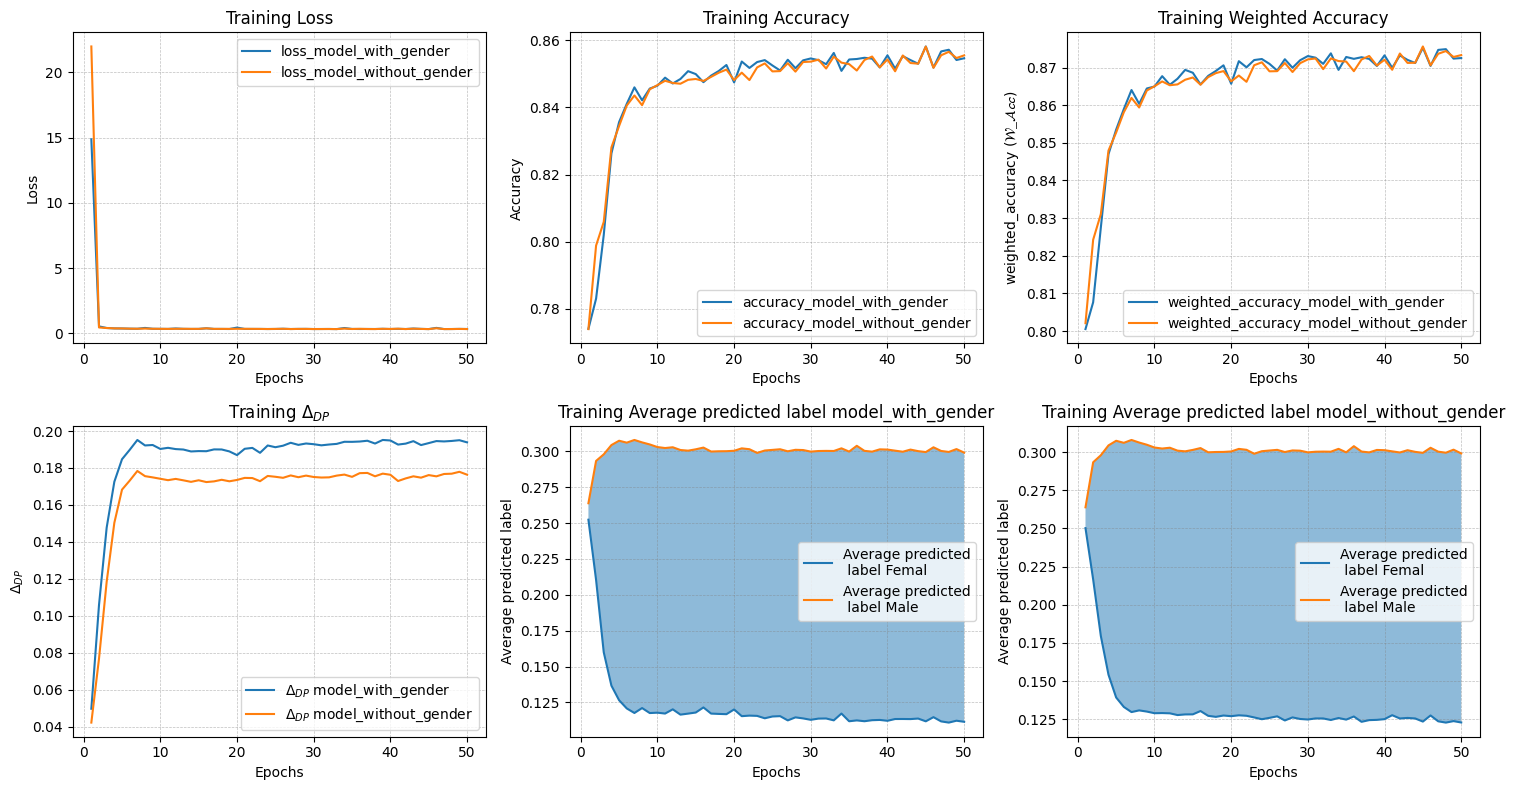

In [65]:
plt.figure(figsize=(15, 8))

ax1 = plt.subplot(2, 3, 1)
x = range(1, len(history_model_with_gender.history['loss_cross_entropy']) + 1)
plt.plot(x, history_model_with_gender.history['loss_cross_entropy'], label='loss_model_with_gender')
plt.plot(x, history_model_without_gender.history['loss_cross_entropy'], label='loss_model_without_gender')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.legend()

ax2 = plt.subplot(2, 3, 2)
plt.plot(x, history_model_with_gender.history['accuracy'], label='accuracy_model_with_gender')
plt.plot(x, history_model_without_gender.history['accuracy'], label='accuracy_model_without_gender')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.legend()

ax2 = plt.subplot(2, 3, 3)
plt.plot(x, history_model_with_gender.history['weighted_accuracy'], label='weighted_accuracy_model_with_gender')
plt.plot(x, history_model_without_gender.history['weighted_accuracy'], label='weighted_accuracy_model_without_gender')
plt.title('Training Weighted Accuracy')
plt.xlabel('Epochs')
plt.ylabel('weighted_accuracy ($\mathcal{W\_Acc}$)')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.legend()

ax2 = plt.subplot(2, 3, 4)
plt.plot(x, history_model_with_gender.history['delta_dp'], label='$\\Delta_{DP}$ model_with_gender')
plt.plot(x, history_model_without_gender.history['delta_dp'], label='$\\Delta_{DP}$ model_without_gender')
plt.title('Training $\\Delta_{DP}$')
plt.xlabel('Epochs')
plt.ylabel('$\\Delta_{DP}$')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.legend()

ax2 = plt.subplot(2, 3, 5)
plt.plot(x, history_model_with_gender.history['y_pred_labels_female_avg'], label='Average predicted\n label Femal')
plt.plot(x, history_model_without_gender.history['y_pred_labels_male_avg'], label='Average predicted\n label Male')
plt.fill_between(x, history_model_with_gender.history['y_pred_labels_female_avg'],
                 history_model_without_gender.history['y_pred_labels_male_avg'], alpha=0.5)
plt.title('Training Average predicted label model_with_gender')
plt.xlabel('Epochs')
plt.ylabel('Average predicted label')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.legend()

ax2 = plt.subplot(2, 3, 6)
plt.plot(x, history_model_without_gender.history['y_pred_labels_female_avg'], label='Average predicted\n label Femal')
plt.plot(x, history_model_without_gender.history['y_pred_labels_male_avg'], label='Average predicted\n label Male')
plt.fill_between(x, history_model_without_gender.history['y_pred_labels_female_avg'],
                 history_model_without_gender.history['y_pred_labels_male_avg'], alpha=0.5)
plt.title('Training Average predicted label model_without_gender')
plt.xlabel('Epochs')
plt.ylabel('Average predicted label')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()


## Performance Evaluation 




Let analyze the overall *accuracy* $\mathcal{Acc}$, *weighted accuracy* $\mathcal{W\_Acc}$, and $\Delta_{DP}$ on the test set with and without gender features:


c:\Users\micha\Desktop\deakin stuff\python3.11_task_3.3HD\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


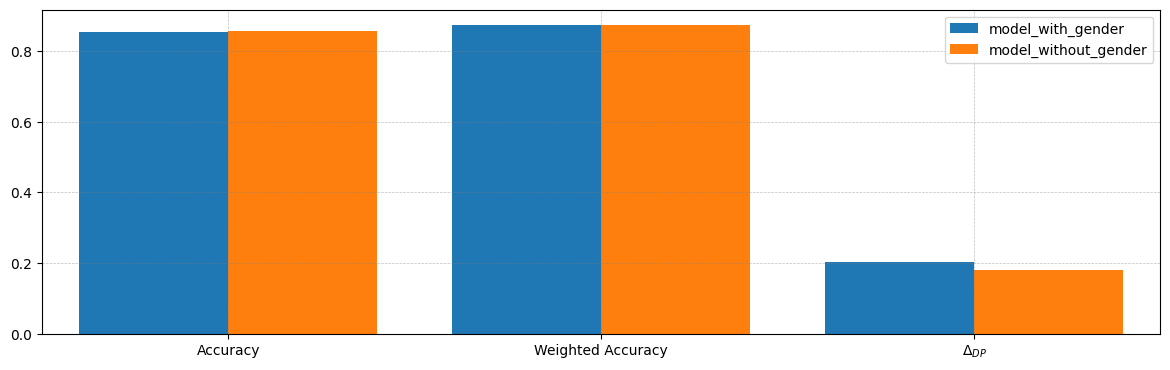

In [66]:
X_train, y_train, a_train, X_test, y_test, a_test, headers = load_data(remove_gender_feature=False)
y_pred = model_with_gender.predict(X_test, verbose=0)
accuracy, weighted_accuracy, delta_dp, y_pred_labels_female_avg, y_pred_labels_male_avg = compute_test_metrics(y_test,
                                                                                                               y_pred,
                                                                                                               a_test)

df = pd.DataFrame(columns=['model', 'metric', 'value'])
data_list = [['model_with_gender', 'Accuracy', accuracy.numpy()],
             ['model_with_gender', 'Weighted Accuracy', weighted_accuracy.numpy()],
             ['model_with_gender', '$\\Delta_{DP}$', delta_dp.numpy()]]
df = pd.concat([df, pd.DataFrame(data_list, columns=['model', 'metric', 'value'])], ignore_index=True)

X_train, y_train, a_train, X_test, y_test, a_test, headers = load_data(remove_gender_feature=True)
y_pred = model_without_gender.predict(X_test, verbose=0)
accuracy, weighted_accuracy, delta_dp, y_pred_labels_female_avg, y_pred_labels_male_avg = compute_test_metrics(y_test,
                                                                                                               y_pred,
                                                                                                               a_test)
data_list = [['model_without_gender', 'Accuracy', accuracy.numpy()],
             ['model_without_gender', 'Weighted Accuracy', weighted_accuracy.numpy()],
             ['model_without_gender', '$\\Delta_{DP}$', delta_dp.numpy()]]
df = pd.concat([df, pd.DataFrame(data_list, columns=['model', 'metric', 'value'])], ignore_index=True)

# Draw plot
g = sns.catplot(x="metric", y='value', hue="model", data=df, kind='bar',
                hue_order=['model_with_gender', 'model_without_gender'],
                legend=False, height=4, aspect=3, saturation=1)

g.despine(top=False, right=False)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

plt.xlabel("")
plt.ylabel("")
plt.gca().legend().set_title('')
plt.show()


### <span style="color:red"><b>TASK 5</b></span>

What do you conclude from the plot above?

***

From the plot, we can conclude that including gender features in the model leads to higher accuracy and weighted accuracy, but also results in a larger demographic parity gap ($\Delta_{DP}$), indicating less fairness. Removing gender features reduces the demographic parity gap, making the model fairer, but may slightly decrease accuracy. This demonstrates the trade-off between model performance and fairness: using sensitive attributes can improve predictive power but risks introducing bias, while excluding them can promote fairness at the potential cost of accuracy.


***

## Prediction Correlation Analysis

Let’s take a look at how the features in our **test data set without gender features** correlate with the learned predictor $\mathbf{\hat{y}}$. 

### <span style="color:red"><b>TASK 6</b></span>

Which 10 features in the data are most correlated with $\hat{y}$? 

In [67]:
X_train, y_train, a_train, X_test, y_test, a_test, headers = load_data(remove_gender_feature=True)
## START YOU CODE HERE
# Get predicted labels from the model trained without gender features
y_pred_labels = model_without_gender.predict(X_test, verbose=0).reshape(-1)
top_indices, correlations = get_top_correlated_features(X_test, y_pred_labels)
## END
for i, idx in enumerate(top_indices):
    print(f'{i+1}- {headers[idx]}:  {correlations[idx]}')

1- marital-status_Married-civ-spouse:  0.6608704133452893
2- relationship_Husband:  0.599370558221229
3- marital-status_Never-married:  -0.48410854246517776
4- education_num:  0.48083219240887154
5- age_u30:  -0.35868303525344397
6- relationship_Own-child:  -0.34087591676897927
7- hours-per-week:  0.3388992493518676
8- capital-gain:  0.3174835571634859
9- occupation_Exec-managerial:  0.30170136739491804
10- relationship_Not-in-family:  -0.27919267131058895


c:\Users\micha\Desktop\deakin stuff\python3.11_task_3.3HD\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


### <span style="color:red"><b>TASK 7</b></span>

Which three features are most correlated with $\mathbf{\hat{y}}$, only looking at examples where $\mathbf{a}^{(i)} = 0$? 

In [68]:
X_train, y_train, a_train, X_test, y_test, a_test, headers = load_data(remove_gender_feature=True)
## START YOU CODE HERE
# Get predicted labels from the model trained without gender features
y_pred_labels = model_without_gender.predict(X_test, verbose=0).reshape(-1)
# Select only examples where a_test == 0 (female)
mask_a0 = (a_test.reshape(-1) == 0)
X_test_a0 = X_test[mask_a0]
y_pred_a0 = y_pred_labels[mask_a0]
top_indices, correlations = get_top_correlated_features(X_test_a0, y_pred_a0, k=3)
## END
for i, idx in enumerate(top_indices):
    print(f'{i+1}- {headers[idx]}:  {correlations[idx]}')

1- relationship_Wife:  0.6788233705530662
2- marital-status_Married-civ-spouse:  0.6438596501584122
3- education_num:  0.38389141902492097


### <span style="color:red"><b>TASK 8</b></span>

Which three features are most correlated with $\mathbf{\hat{y}}$, only looking at examples where $\mathbf{a}^{(i)} = 1$?

In [69]:
X_train, y_train, a_train, X_test, y_test, a_test, headers = load_data(remove_gender_feature=True)
## START YOU CODE HERE
# Get predicted labels from the model trained without gender features
y_pred_labels = model_without_gender.predict(X_test, verbose=0).reshape(-1)
# Select only examples where a_test == 1 (male)
mask_a1 = (a_test.reshape(-1) == 1)
X_test_a1 = X_test[mask_a1]
y_pred_a1 = y_pred_labels[mask_a1]
top_indices, correlations = get_top_correlated_features(X_test_a1, y_pred_a1, k=3)
## END
for i, idx in enumerate(top_indices):
    print(f'{i+1}- {headers[idx]}:  {correlations[idx]}')

1- relationship_Husband:  0.6204149189581853
2- marital-status_Married-civ-spouse:  0.6140315532586195
3- education_num:  0.5423604333691722


## Integrating Statistical Parity into Training Objective

In this second part of the assignment, we will use the **data set without gender features**.

Change the training objective to include a term that estimates the lack of statistical
parity on the training set ($\Delta_{DP}$), with a hyperparameter $\alpha$ to control the weighting
of this term relative to accuracy. 

**Remark:** Note that the new regularizer term must be differentiable w.r.t. the network parameters, so functions of the hard predictions $\mathbf{\hat{y}}^{(i)}\in \{0, 1\}$  (computed by thresholding network output, for example) are not permissible. 

Formally, the loss function to implement is the following:


\begin{equation}
\mathcal{L}(\mathbf{\hat{y}},\mathbf{y},\mathbf{a}) =\overbrace{\frac{1}{m} \sum_{i=1}^m \mathbf{y}^{(i)} log (\mathbf{\hat{y}}^{(i)})}^{\text{Cross-Entropy Loss}}   + \alpha \times \overbrace{\left| \frac{1}{m_{\mathbf{a}=0}} \sum_{i=1}^m P(\mathbf{\hat{y}}^{(i)}=1|\mathbf{x}^{(i)}) \cdot (1-\mathbf{a}^{(i)}) - 
\frac{1}{m_{\mathbf{a}=1}} \sum_{i=1}^m  P(\mathbf{\hat{y}}^{(i)}=1|\mathbf{x}^{(i)}) \cdot \mathbf{a}^{(i)} \right|}^{\Delta_{DP}\text{ Loss}} \tag{4}
\end{equation}

where $P(\mathbf{\hat{y}}^{(i)}=1|\mathbf{x}^{(i)})$ is the predicted probability of the positive class for the example $\mathbf{x}^{(i)}$.


### <span style="color:red"><b>TASK 9</b></span>

Let's first define the model:


In [70]:
class CustomModel_Extended(CustomModel):
    def __init__(self, alpha=6, **kwargs):
        super(CustomModel_Extended, self).__init__(**kwargs)

        # Define the losses to track
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.loss_delta_dp_tracker = keras.metrics.Mean(name="loss_delta_dp")

        # Hyperparameter alpha
        self.alpha = alpha

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.loss_cross_entropy_tracker,
            self.loss_delta_dp_tracker,

            self.accuracy_tracker,
            self.weighted_accuracy_tracker,
            self.delta_dp_tracker,
            self.y_pred_labels_female_avg_tracker,
            self.y_pred_labels_male_avg_tracker,
        ]

    def train_step(self, data):
        X, y, a = data[0]  # Unpack the three inputs        
        with tf.GradientTape() as tape:
            ## START YOU CODE HERE
            y_pred = self(X)
            # Binary cross-entropy loss
            loss_cross_entropy = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y, y_pred))

            # Demographic Parity (DP) differentiable loss (soft predictions)
            a = tf.reshape(a, [-1])
            y_pred = tf.reshape(y_pred, [-1])
            female_mask = tf.equal(a, 0)
            male_mask = tf.equal(a, 1)
            m_female = tf.reduce_sum(tf.cast(female_mask, tf.float32))
            m_male = tf.reduce_sum(tf.cast(male_mask, tf.float32))
            y_pred_female_avg = tf.reduce_sum(y_pred * tf.cast(female_mask, tf.float32)) / (m_female + 1e-8)
            y_pred_male_avg = tf.reduce_sum(y_pred * tf.cast(male_mask, tf.float32)) / (m_male + 1e-8)
            loss_delta_dp = tf.abs(y_pred_female_avg - y_pred_male_avg)
            # Total loss: cross-entropy + alpha * DP loss
            total_loss = loss_cross_entropy + self.alpha * loss_delta_dp
            ## END

        # Compute gradients and update weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.loss_cross_entropy_tracker.update_state(loss_cross_entropy)
        self.loss_delta_dp_tracker.update_state(loss_delta_dp)

        # Perform evaluation
        X, y, a = data[0]  # Unpack the three inputs
        y_pred = self(X)
        accuracy, weighted_accuracy, delta_dp, y_pred_labels_female_avg, y_pred_labels_male_avg = compute_test_metrics(
            y, y_pred, a)

        # Update evaluation trackers
        self.accuracy_tracker.update_state(accuracy)
        self.weighted_accuracy_tracker.update_state(weighted_accuracy)
        self.delta_dp_tracker.update_state(delta_dp)
        self.y_pred_labels_female_avg_tracker.update_state(y_pred_labels_female_avg)
        self.y_pred_labels_male_avg_tracker.update_state(y_pred_labels_male_avg)

        return {
            "total_loss": self.total_loss_tracker.result(),
            "loss_cross_entropy": self.loss_cross_entropy_tracker.result(),
            "loss_delta_dp": self.loss_delta_dp_tracker.result(),

            "accuracy": self.accuracy_tracker.result(),
            "weighted_accuracy": self.weighted_accuracy_tracker.result(),
            "delta_dp": self.delta_dp_tracker.result(),
            "y_pred_labels_female_avg": self.y_pred_labels_female_avg_tracker.result(),
            "y_pred_labels_male_avg": self.y_pred_labels_male_avg_tracker.result(),
        }

Let's now train our model:

In [71]:
###### PLEASE DO NOT REMOVE THIS!#########
# Set the random seed for NumPy
np.random.seed(seed_value)
# Set the random seed for TensorFlow
tf.random.set_seed(seed_value)
# Set the random seed for Keras
tf.keras.utils.set_random_seed(seed_value)
##########################################
X_train, y_train, a_train, X_test, y_test, a_test, headers = load_data(remove_gender_feature=True)

model = CustomModel_Extended(alpha=0.64)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))
model.build(input_shape=X_train.shape)
print(model.summary())
history = model.fit([X_train, y_train, a_train], epochs=50, batch_size=128)


Model: "custom_model__extended_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_270 (Dense)           multiple                  7168      
                                                                 
 dense_271 (Dense)           multiple                  2080      
                                                                 
 dense_272 (Dense)           multiple                  33        
                                                                 
Total params: 9297 (36.32 KB)
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_270 (Dense)           multiple                  7168      
                                                                 
 dense_271 (Dense)           multiple                  2080      
                                                                 
 dense_272 

Plot learning curve

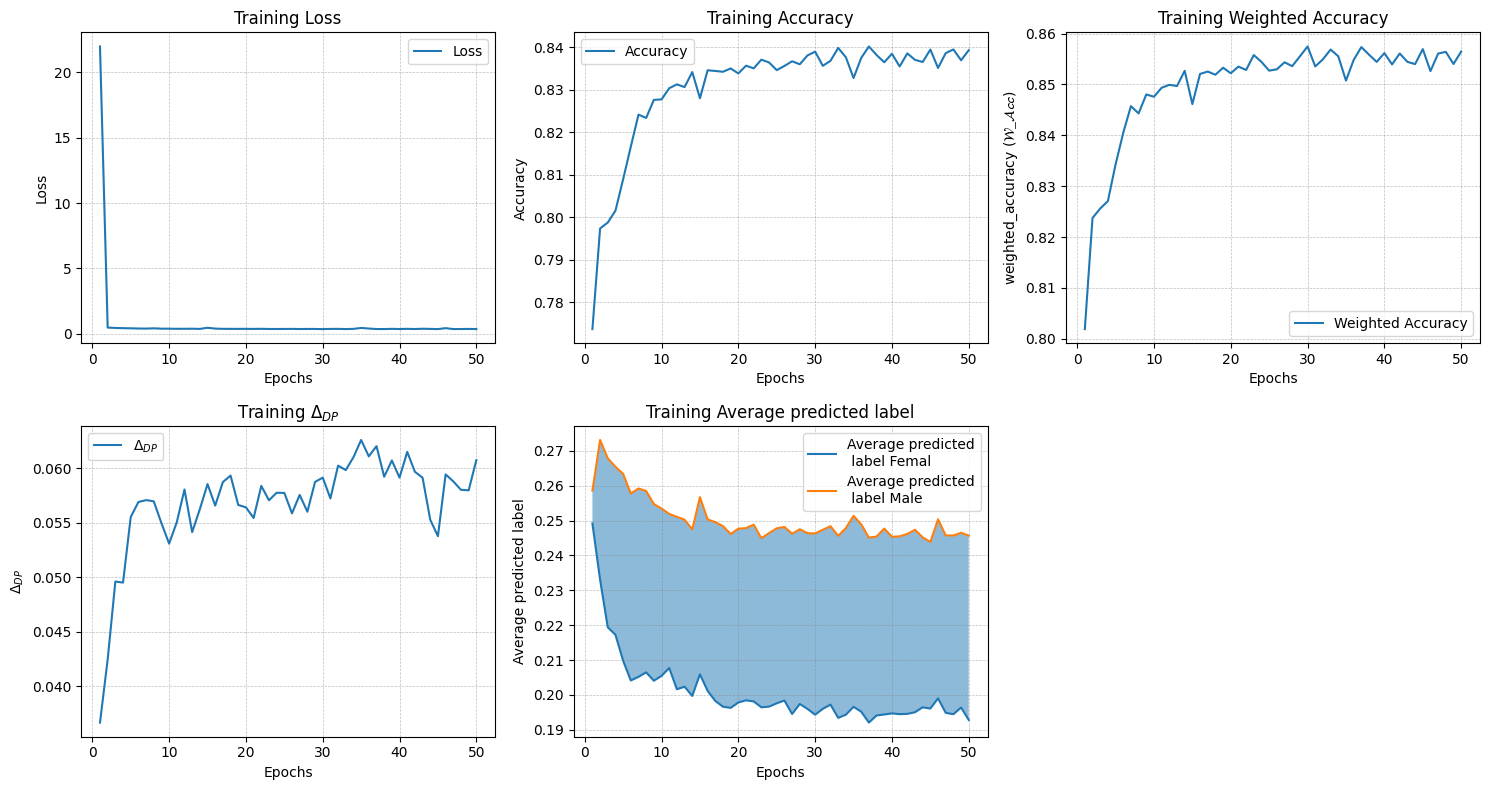

In [72]:
plt.figure(figsize=(15, 8))

ax1 = plt.subplot(2, 3, 1)
x = range(1, len(history.history['loss_cross_entropy']) + 1)
plt.plot(x, history.history['loss_cross_entropy'], label='Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.legend()

ax2 = plt.subplot(2, 3, 2)
plt.plot(x, history.history['accuracy'], label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.legend()

ax2 = plt.subplot(2, 3, 3)
plt.plot(x, history.history['weighted_accuracy'], label='Weighted Accuracy')
plt.title('Training Weighted Accuracy')
plt.xlabel('Epochs')
plt.ylabel('weighted_accuracy ($\mathcal{W\_Acc}$)')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.legend()

ax2 = plt.subplot(2, 3, 4)
plt.plot(x, history.history['delta_dp'], label='$\\Delta_{DP}$ ')
plt.title('Training $\\Delta_{DP}$')
plt.xlabel('Epochs')
plt.ylabel('$\\Delta_{DP}$')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.legend()

ax2 = plt.subplot(2, 3, 5)
plt.plot(x, history.history['y_pred_labels_female_avg'], label='Average predicted\n label Femal')
plt.plot(x, history.history['y_pred_labels_male_avg'], label='Average predicted\n label Male')
plt.fill_between(x, history.history['y_pred_labels_female_avg'],
                 history.history['y_pred_labels_male_avg'], alpha=0.5)
plt.title('Training Average predicted label')
plt.xlabel('Epochs')
plt.ylabel('Average predicted label')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()


## Exploring the Impact of $\alpha$ on Neural Network Performance

### <span style="color:red"><b>TASK 10</b></span>


Determine a range of $\alpha$ that produces reasonable results when training the neural network and report this range in your writeup. Carry out a sequence of network trainings with $\alpha$ varying over this range, and produce a plot (similar to the one described above) where accuracy (overall and weighted) and $\alpha$ are shown as functions of $\alpha$.

In [73]:
###### PLEASE DO NOT REMOVE THIS!#########
# Set the random seed for NumPy
np.random.seed(seed_value)
# Set the random seed for TensorFlow
tf.random.set_seed(seed_value)
# Set the random seed for Keras
tf.keras.utils.set_random_seed(seed_value)
##########################################
X_train, y_train, a_train, X_test, y_test, a_test, headers = load_data(remove_gender_feature=True)

alpha_values = [0, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56, 5.12, 10,
                15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 80, 85, 90, 95,
                100, 150, 200, 256, 512, 1024, 2048, 4096, 8192, 10000, 20000, 30000,40000,50000]
accuracy_values = []
weighted_accuracy_values = []
delta_dp_values = []

for alpha in tqdm(alpha_values, ncols=80):
    ## START YOU CODE HERE
    # Reinitialize model for each alpha
    model = CustomModel_Extended(alpha=alpha)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))
    model.build(input_shape=X_train.shape)
    # Train for fewer epochs for speed (e.g., 10 epochs)
    history = model.fit([X_train, y_train, a_train], epochs=10, batch_size=128, verbose=0)
    # Evaluate on test set
    y_pred = model.predict(X_test, verbose=0)
    accuracy, weighted_accuracy, delta_dp, _, _ = compute_test_metrics(y_test, y_pred, a_test)
    accuracy_values.append(float(accuracy.numpy()))
    weighted_accuracy_values.append(float(weighted_accuracy.numpy()))
    delta_dp_values.append(float(delta_dp.numpy()))
    ## END

100%|███████████████████████████████████████████| 41/41 [05:16<00:00,  7.71s/it]


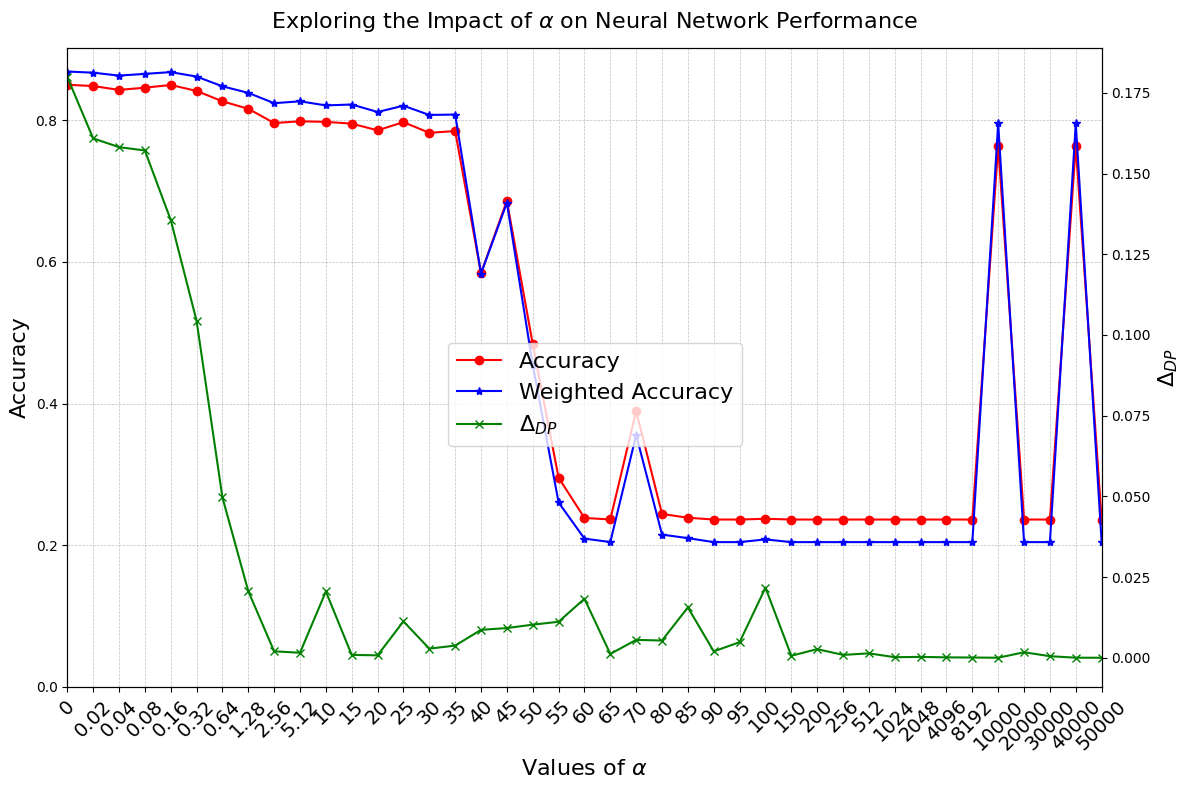

In [74]:
fig, ax1 = plt.subplots(figsize=(12, 8))
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
x = list(range(len(alpha_values)))
         
ax1.plot(x, accuracy_values, 'r-o')
ax1.plot(x, weighted_accuracy_values, 'b-*')
ax1.set_xlabel('Values of $\\alpha$', fontsize=16)
ax1.set_ylabel('Accuracy', fontsize=16)
ax1.set_xlim(0, x[-1])  
ax1.set_ylim(0, None) 
ax1.set_xticks(x)

ax1.set_xticklabels(alpha_values, rotation=45, fontsize=14)

ax2 = ax1.twinx()
ax2.plot(x, delta_dp_values, 'g-x')
ax2.set_ylabel('$\\Delta_{DP}$', fontsize=16)
fig.legend(labels = ('Accuracy','Weighted Accuracy', '$\\Delta_{DP}$'), loc='center', fontsize=16)

fig.suptitle('Exploring the Impact of $\\alpha$ on Neural Network Performance', fontsize=16)
plt.tight_layout()
plt.show()


### <span style="color:red"><b>TASK 11</b></span>

What do you observe from the plot above?

***

From the plot, we observe that as the value of $\alpha$ increases, the demographic parity gap ($\Delta_{DP}$) generally decreases, indicating improved fairness. However, increasing $\alpha$ too much can lead to a reduction in both overall accuracy and weighted accuracy, as the model prioritizes fairness over predictive performance. There is a range of $\alpha$ values where the model achieves a good balance between accuracy and fairness, but beyond this range, the trade-off gets increasingly noticeable.. This demonstrates the importance of tuning $\alpha$ to achieve the desired balance for a given application.


***

## Overall Performance Comparaison

Let's now see a performance comparaison of the the three models we have have built in this assigment:
 - Model trained with gender features.
 - Model trained without gender features.
 - Model trained without gender features and with cross-entropy and $\Delta_{DP}$ loss.

c:\Users\micha\Desktop\deakin stuff\python3.11_task_3.3HD\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


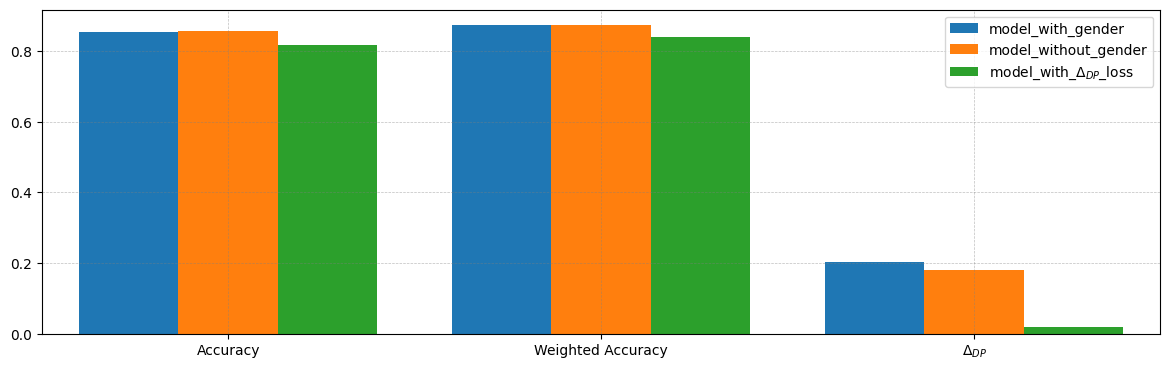

In [75]:
data_list = [['model_with_$\\Delta_{DP}$_loss', 'Accuracy', accuracy_values[7]],
             ['model_with_$\\Delta_{DP}$_loss', 'Weighted Accuracy', weighted_accuracy_values[7]],
             ['model_with_$\\Delta_{DP}$_loss', '$\\Delta_{DP}$', delta_dp_values[7]]]
df_new = pd.concat([df, pd.DataFrame(data_list, columns=['model', 'metric', 'value'])], ignore_index=True)
# Draw plot
g = sns.catplot(x="metric", y='value', hue="model", data=df_new, kind='bar',
                hue_order=['model_with_gender', 'model_without_gender','model_with_$\\Delta_{DP}$_loss'],
                legend=False, height=4, aspect=3, saturation=1)

g.despine(top=False, right=False)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

plt.xlabel("")
plt.ylabel("")
plt.gca().legend().set_title('')
plt.show()


### <span style="color:red"><b>TASK 12</b></span>

What do you observe from the plot above?

***

The final comparison plot shows that the model trained with both cross-entropy and $\Delta_{DP}$ loss achieves a better balance between accuracy and fairness compared to the other two models. While the model with gender features has the highest accuracy, it also has the largest demographic parity gap, indicating less fairness. The model without gender features is fairer but may sacrifice some accuracy. The fairness-regularized model (with $\Delta_{DP}$ loss) reduces the demographic parity gap significantly while maintaining competitive accuracy, demonstrating that fairness constraints can help mitigate bias without severely impacting performance.


***

# Congratulations!


Congratulations on completing the assignment! Your dedication and effort are commendable. By successfully working through the coding exercises and written exercises, you have demonstrated a strong understanding of the concepts and principles related to fairness in AI.

It is crucial to recognize the importance of considering fairness in AI systems. As AI technologies become more prevalent in various domains, including decision-making processes, it is imperative to ensure that these systems treat all individuals fairly and avoid perpetuating biases or discrimination. By incorporating fairness considerations into the design, development, and evaluation of AI models, we can strive to create more equitable and just outcomes for everyone. Your engagement with this assignment highlights the significance of fairness in AI and the need for continuous efforts to address biases and promote fairness in algorithmic decision-making. Well done!

Congratulations on finishing this notebook! 

